<a href="https://colab.research.google.com/github/Ashrafalaghbari/oil-production-forecasting/blob/main/Optimal_TCN_LSTM_GA_single_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries and define functions

In [ ]:
%autosave 60

Autosaving every 60 seconds


In [1]:
import os
import numpy as np
import random 
from numpy.random import randint, rand
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import itertools
import re
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Activation, Input, Flatten
from keras.layers import LSTM, Conv1D
from keras.models import Model
import keras.backend as k
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt, inf

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
# # check if GPU is utilized 
# device_name = tf.config.experimental.list_physical_devices()[-1][-1]
# if device_name != 'GPU':
#     raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(tf.test.gpu_device_name()))

In [2]:
# Select the best features
def select_features(df, target, correlation_type, threshold):
    if (threshold < -1 ) | (threshold > 1 ) :
            raise SystemError('correlation threshold is out of bounds')
    features = df.corr(correlation_type).loc[target].drop(target)
    best_features = features.where(abs(features) > threshold).dropna()
    df = pd.concat([df[target], df[best_features.index]], axis=1)
    return df

# convert series to supervised learning using a sliding  window approach
def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (columns[j], i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# scale train and test data to new feature range[0, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(0, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled


#Evaluation metrics
# compute RMSPE
def RMSPE(x,y):
	result=0
	for i in range(len(x)):
		result += ((x[i]-y[i])/x[i])**2
	result /= len(x)
	result = sqrt(result)
	result *= 100
	return result

# compute MAPE
def MAPE(x,y):
	result=0
	for i in range(len(x)):
		result += abs((x[i]-y[i])/x[i])
	result /= len(x)
	result *= 100
	return result

# compute wMAPE weighted absolute percentage error
def wMAPE(actual, predicted): 
    result_nom = 0
    result_deno = 0
    for i in range(len(actual)):
        result_nom +=  abs(actual[i] - predicted[i])
        result_deno +=  abs(actual[i]) 
    result = result_nom/result_deno
    return result *100

def SMAPE(actual, predicted): #Symmetric (adjusted) MEAN ABSOLUTE PERCENTAGE ERROR (SMAPE)
    result = 0
    for i in range(len(actual)):
        result += abs(actual[i] - predicted[i])/(abs(actual[i]) + abs(predicted[i]))
    result = 2 * result/ len(actual) 
    return result * 100

# Evaluate LSTM using GA

In [ ]:
# Evalaute LSTM model with the random generated combinations by GA
def evaluate_LSTM(individual, steps_ahead=1):

    n_epochs = individual[0]
    num_hidden_layers = individual[1]
    num_neurons = individual[2]
    batch_size = individual[3]
    window_size = individual[4]
  

    print('n_epochs', n_epochs, 'num_hidden_layers', num_hidden_layers, 'num_neurons',
              num_neurons, "batch_size", str(batch_size), 'window_size', window_size)

    # setting the session configurations for reproducibility.
    combinations = [n_epochs, num_hidden_layers, num_neurons, batch_size, window_size]
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    os.environ['PYTHONHASHSEED'] = '0'
    # seed = int(random.random()*(2**32-1))
    np.random.seed(42)
    np.random.seed(12345)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                        inter_op_parallelism_threads=1)
    from keras import backend as K   
    tf.random.set_seed(1234)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), 
                            config=session_conf)
    K.set_session(sess)

    #feature engineering
    # # convert the stationary series to supervise learning
    series_supervised = series_to_supervised(series, series.columns, n_in= window_size, n_out= steps_ahead, dropnan=True)   

    # drop columns we don't want to predict
    pattern = re.compile(r"(t-)|^BORE_OIL_VOL.*")
    # Extract the column names that match the pattern
    matching_columns = [col for col in series_supervised.columns if re.search(pattern, col)]
    series_supervised = series_supervised[matching_columns]

    # # split into train and test sets
    series_supervised = series_supervised.values
    train_size = int(series_supervised.shape[0] * 0.8)
    test_size = series_supervised.shape[0] - train_size
    train, test = series_supervised[0:train_size], series_supervised[train_size:]
    # print("train.shape:",train.shape, "test.shape:",test.shape)

    # scale  the data to a feature range(0,1)
    scaler, train_scaled, test_scaled = scale(train, test)
    # print('train_scaled.shape:',train_scaled.shape, "test_scaled.shape:",test_scaled.shape)

    # reshape input to be 3D [samples, window_size, features]
    n_features = len(series.columns)
    train_X, train_y = train_scaled[:, 0:-steps_ahead], train_scaled[:, -steps_ahead:]
    train_X = train_X.reshape(train_X.shape[0], window_size, n_features)
    test_X, test_y = test_scaled[:, 0:-steps_ahead], test_scaled[:, -steps_ahead:]
    test_X = test_X.reshape(test_X.shape[0], window_size, n_features )
    # print("train_X.shape:",train_X.shape, "train_y.shape:",train_y.shape,
    #         "test_X.shape:", test_X.shape,"test_y.shape:",test_y.shape)

    # build the LSTM model
    model =  Sequential()

    if num_hidden_layers == 1:
        model.add(LSTM(num_neurons, activation='tanh', input_shape = (window_size, n_features)))
        
    else:
        for num in range(num_hidden_layers-1):
            model.add(LSTM(num_neurons,activation='tanh', input_shape =(window_size, n_features), return_sequences=True))        
        model.add(LSTM(num_neurons))
            
    model.add(Dense(steps_ahead))
    model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
    #prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0,
                                restore_best_weights=True, mode='min')

    model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, callbacks = [early_stopping],
                validation_data=(test_X, test_y), verbose=0, shuffle=False)
    
    # # save the weights to a HDF5 file
    # combination = [n_epochs, num_hidden_layers, num_neurons, batch_size, window_size]
    # model.save_weights(f'{combination}_weights.h5')

    return model.evaluate(test_X, test_y, verbose=0)

# Evaluate TCN using GA

In [ ]:
# Evalaute TCN model with the random generated combinations by GA
def evaluate_TCN(individual, steps_ahead=1):

    n_epochs = individual[0]
    n_filters_1 = individual[1]
    n_filters_2 = individual[2]
    n_filters_3 = individual[3]
    batch_size = individual[4]
    window_size = individual[5]


    print('n_epochs', n_epochs, 'n_filters_1', n_filters_1, 'n_filters_2',n_filters_2, 'n_filters_3', n_filters_3,
               "batch_size", batch_size, 'window_size', window_size)
    
    # setting the session configurations for reproducibility.
    combinations = [n_epochs, n_filters_1, n_filters_2, n_filters_3, batch_size, window_size]
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    os.environ['PYTHONHASHSEED'] = '0'
    # seed = int(random.random()*(2**32-1))
    np.random.seed(42)
    np.random.seed(12345)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                        inter_op_parallelism_threads=1)
    from keras import backend as K   
    tf.random.set_seed(1234)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), 
                            config=session_conf)
    K.set_session(sess)

    #feature engineering
    # # convert the stationary series to supervise learning
    series_supervised = series_to_supervised(series, series.columns, n_in= window_size, n_out= steps_ahead, dropnan=True)   

    # drop columns we don't want to predict
    pattern = re.compile(r"(t-)|^BORE_OIL_VOL.*")
    # Extract the column names that match the pattern
    matching_columns = [col for col in series_supervised.columns if re.search(pattern, col)]
    series_supervised = series_supervised[matching_columns]

    # # split into train and test sets
    series_supervised = series_supervised.values
    train_size = int(series_supervised.shape[0] * 0.8)
    test_size = series_supervised.shape[0] - train_size
    train, test = series_supervised[0:train_size], series_supervised[train_size:]
    # print("train.shape:",train.shape, "test.shape:",test.shape)

    # scale  the data to a feature range(0,1)
    scaler, train_scaled, test_scaled = scale(train, test)
    # print('train_scaled.shape:',train_scaled.shape, "test_scaled.shape:",test_scaled.shape)

    # reshape input to be 3D [samples, window_size, features]
    n_features = len(series.columns)
    train_X, train_y = train_scaled[:, 0:-steps_ahead], train_scaled[:, -steps_ahead:]
    train_X = train_X.reshape(train_X.shape[0], window_size, n_features)
    test_X, test_y = test_scaled[:, 0:-steps_ahead], test_scaled[:, -steps_ahead:]
    test_X = test_X.reshape(test_X.shape[0], window_size, n_features )
    # print("train_X.shape:",train_X.shape, "train_y.shape:",train_y.shape,
            # "test_X.shape:", test_X.shape,"test_y.shape:",test_y.shape)

    # build the TCN model
    input_tensor=Input(shape=(window_size, n_features))

    #Feature extraction module
    conv1 = Conv1D(filters = n_filters_1, kernel_size = 1, dilation_rate=1 ,padding='same')(input_tensor)
    conv2 = Conv1D(filters = n_filters_2 , kernel_size = 1, dilation_rate=1, padding='same')(conv1)
    # Time information extraction module
    conv3 = Conv1D(filters = n_filters_3, kernel_size= window_size, dilation_rate=1, padding='causal')(conv2) 
    
    conv3 = Flatten()(conv3)  
    outputs = Dense(steps_ahead)(conv3)
    model = Model(input_tensor, outputs)

    model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
    #prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0,
                                restore_best_weights=True, mode='min')
    
    model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, callbacks = [early_stopping],
              validation_data=(test_X, test_y), verbose=0, shuffle=False)
    
    return model.evaluate(test_X, test_y, verbose=0)

# GA

In [ ]:
# decode bitstring to numbers
def decode(bounds, n_bits, bitstring):
    decoded = list()
    largest = 2**n_bits
    for i in range(len(bounds)):
        # extract the substring
        start, end = i * n_bits, (i * n_bits)+n_bits
    
        substring = bitstring[start:end]
        # convert bitstring to a string of chars
        chars = ''.join([str(s) for s in substring])
        # convert string to integer
        integer = int(chars, 2)
        # scale integer to desired range
        value = bounds[i][0] + (integer/largest) * (bounds[i][1] - bounds[i][0])
        value = np.round(value)
        value = int(value)
        # store
        decoded.append(value)
    return decoded

# tournament selection
def selection(pop, scores, k=3):
	# first random selection
	selection_ix = randint(len(pop))
	for ix in randint(0, len(pop), k-1):
		# check if better (e.g. perform a tournament)
		if scores[ix] < scores[selection_ix] : # which individual has the lowest loss

			selection_ix = ix
	return pop[selection_ix]

# crossover two parents to create two children
def crossover(p1, p2, r_cross):
	# children are copies of parents by default
	c1, c2 = p1.copy(), p2.copy()
	# check for recombination
	if rand() < r_cross:
		# select crossover point that is not on the end of the string
		pt = randint(1, len(p1)-2)
		# perform crossover
		c1 = np.append(p1[:pt] , p2[pt:])
		c2 = np.append(p2[:pt] , p1[pt:])
	return [c1, c2]

# mutation operator
def mutation(bitstring, r_mut):
	for i in range(len(bitstring)):
		# check for a mutation
		if rand() < r_mut:
			# flip the bit
			bitstring[i] = 1 - bitstring[i]

# genetic algorithm
def genetic_algorithm(evaluate, bounds, n_bits, n_iter, n_pop, r_cross, r_mut):
    random.seed()
    # initial population of random bitstring
    pop = [randint(0, 2, n_bits*len(bounds)).tolist() for _ in range(n_pop)]
    # keep track of best solution
    best, best_eval = 0, inf
    # enumerate generations
    for gen in range(1, n_iter+1):
        print(f"Generation:{gen}")
        # decode population
        decoded = [decode(bounds, n_bits, p) for p in pop]
        # evaluate all candidates in the population
        scores = [evaluate(ind) for ind in decoded]
        # check for new best solution
        for i in range(n_pop):
            if scores[i] < best_eval: # find the lowest validation loss
                best, best_eval = pop[i], scores[i]
                # print(">%d, new best combination, Epoch: %d, num_hidden_layers: %d, num_neurons:%d, batch_size: %d, window_size: %d, Loss = %.8f" % \
                #         (gen,  decoded[i][0],decoded[i][1], decoded[i][2], decoded[i][3], decoded[i][4],
                #                                             scores[i]))
                print(">%d, new best combination, Epoch: %d, n_filters_1: %d, n_filters_2: %d, n_filters_3: %d, batch_size: %d, window_size: %d, Loss = %.8f" % \
                        (gen,  decoded[i][0],decoded[i][1], decoded[i][2], decoded[i][3], decoded[i][4], decoded[i][5],
                                                            scores[i]))
		# select parents (survival of the fittest)
        selected = [selection(pop, scores) for _ in range(n_pop)]
		# create the next generation
        children = list()
        for i in range(0, n_pop, 2):
			# get selected parents in pairs
            p1, p2 = selected[i], selected[i+1]
			# crossover and mutation
            for c in crossover(p1, p2, r_cross):
				# mutation
                mutation(c, r_mut)
				# store for next generation
                children.append(c)
		# replace population
        pop = children
    return [best, best_eval]

# Import the processed dataset

In [4]:
#load dataset
series = pd.read_csv('/content//model.csv', 
                     parse_dates=["DATEPRD"], index_col="DATEPRD")
print(series.columns, len(series.columns))
days = pd.Series(range(len(series),0, -1 ), index=series.index)
series.insert(0, 'days', days)
series['days(t)'] = series['days'].shift(-1)
series["AVG_CHOKE_SIZE_P(t)"] = series['AVG_CHOKE_SIZE_P'].shift(-1)
series["ON_STREAM_HRS(t)"] = series['ON_STREAM_HRS'].shift(-1)
series['interaction_effect_onNext_oilRate'] = series["AVG_CHOKE_SIZE_P(t)"]  * series["ON_STREAM_HRS(t)"] * series['days(t)']
series.dropna(inplace=True)
# # select feature based on correlation
# # series = select_features(series, "BORE_OIL_VOL", "spearman", 0.2)
# # select features manually
series =series[[
                'interaction_effect_onNext_oilRate',
                "BORE_GAS_VOL", 
                "BORE_OIL_VOL"
                ]] 
series.shape             

Index(['ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE',
       'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE',
       'BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL', 'F_4_ON_STREAM_HRS',
       'F_4_BORE_WI_VOL', 'F_5_ON_STREAM_HRS', 'F_5_BORE_WI_VOL'],
      dtype='object') 14


(1907, 3)

In [ ]:
series.head()

,interaction_effect_onNext_oilRate,BORE_GAS_VOL,BORE_OIL_VOL
DATEPRD,,,
2010-01-01,2.320193e+06,1.462166e+07,18593.749401
2010-01-02,2.180419e+06,1.469266e+07,18701.242265
2010-01-03,2.043969e+06,1.400904e+07,17799.912406
2010-01-04,2.090307e+06,1.341015e+07,17002.616014
2010-01-05,2.103377e+06,1.361768e+07,17270.939334


# Optimizing LSTM hyperparameters with GA



In [ ]:
# optimize the LSTM model
# define the total number of generations
n_iter = 10
# bits per variable
n_bits = 16
# define the number of combinations (individuals) per generation 
n_pop = 20
# crossover rate
r_cross = 0.9
# mutation rate
r_mut = 0.1

# define the search space for LSTM
n_epochs = [500,500]
num_hidden_layers = [1, 2]
num_neurons = [4, 200]
batch_size = [2, 8]
window_size = [2, 12]
bounds_lstm = [n_epochs,num_hidden_layers, num_neurons, batch_size, window_size]


# run optimization
best_comb_lstm, score_lstm = genetic_algorithm(evaluate_LSTM, bounds_lstm, n_bits, n_iter, n_pop, r_cross, r_mut)
print('Done!')
decoded = decode(bounds_lstm, n_bits, best_comb_lstm)
print('LSTM Best: %s = %f' % (decoded, score_lstm))

Generation:1
n_epochs 500 num_hidden_layers 2 num_neurons 175 batch_size 8 window_size 10
n_epochs 500 num_hidden_layers 1 num_neurons 68 batch_size 8 window_size 6
n_epochs 500 num_hidden_layers 2 num_neurons 88 batch_size 4 window_size 3
n_epochs 500 num_hidden_layers 2 num_neurons 133 batch_size 3 window_size 5
n_epochs 500 num_hidden_layers 2 num_neurons 139 batch_size 8 window_size 9
n_epochs 500 num_hidden_layers 2 num_neurons 97 batch_size 7 window_size 5
n_epochs 500 num_hidden_layers 2 num_neurons 94 batch_size 5 window_size 10
n_epochs 500 num_hidden_layers 2 num_neurons 186 batch_size 4 window_size 9
n_epochs 500 num_hidden_layers 1 num_neurons 86 batch_size 6 window_size 3
n_epochs 500 num_hidden_layers 2 num_neurons 95 batch_size 3 window_size 9
n_epochs 500 num_hidden_layers 2 num_neurons 42 batch_size 5 window_size 4
n_epochs 500 num_hidden_layers 2 num_neurons 116 batch_size 3 window_size 7
n_epochs 500 num_hidden_layers 2 num_neurons 62 batch_size 7 window_size 4
n_epo

# Run the LSTM model using the optimal hyperparamters obtained by GA

In [5]:
steps_ahead = 1
# Define hyperparamtes
n_epochs = 500
num_hidden_layers = 1
num_neurons = 68
batch_size = 8
window_size = 10


# # setting the session configurations for reproducibility.

combinations = [n_epochs, num_hidden_layers, num_neurons, batch_size, window_size]
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
np.random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                    inter_op_parallelism_threads=1)
from keras import backend as K   
tf.random.set_seed(1234)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), 
                        config=session_conf)
K.set_session(sess)

# # convert the series to supervise learning using sliding window approach
series_supervised = series_to_supervised(series, series.columns, n_in= window_size, n_out= steps_ahead, dropnan=True)   

# drop columns we don't want to predict
pattern = re.compile(r"(t-)|^BORE_OIL_VOL.*")

# Extract the column names that match the pattern
matching_columns = [col for col in series_supervised.columns if re.search(pattern, col)]
series_supervised = series_supervised[matching_columns]
# # split into train and test sets
n_features = int((len(series_supervised.columns) -steps_ahead)/window_size)
series_supervised = series_supervised.values
train_size = int(series_supervised.shape[0] * 0.8)
test_size = series_supervised.shape[0] - train_size
train, test = series_supervised[0:train_size], series_supervised[train_size:]
print("train.shape:",train.shape, "test.shape:",test.shape)

# scale  the data to a feature range(0,1)
scaler, train_scaled, test_scaled = scale(train, test)
print('train_scaled.shape:',train_scaled.shape, "test_scaled.shape:",test_scaled.shape)

# # reshape input to be 3D [samples, window_size, features]
train_X, train_y = train_scaled[:, 0:-steps_ahead], train_scaled[:, -steps_ahead:]
train_X = train_X.reshape(train_X.shape[0], window_size, n_features)
test_X, test_y = test_scaled[:, 0:-steps_ahead], test_scaled[:, -steps_ahead:]
test_X = test_X.reshape(test_X.shape[0], window_size, n_features )
print("train_X.shape:",train_X.shape, "train_y.shape:",train_y.shape,
        "test_X.shape:", test_X.shape,"test_y.shape:",test_y.shape)

#Run the model
model_lstm =  Sequential()

if num_hidden_layers == 1:
    model_lstm.add(LSTM(num_neurons, activation='tanh', input_shape = (window_size, n_features)))
    
else:
    for num in range(num_hidden_layers-1):
        model_lstm.add(LSTM(num_neurons,activation='tanh', input_shape =(window_size, n_features), return_sequences=True))        
    model_lstm.add(LSTM(num_neurons))
        
model_lstm.add(Dense(steps_ahead))
model_lstm.compile(loss='mean_squared_error',
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
#prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0,
                            restore_best_weights=True, mode='min')
history_lstm = model_lstm.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, callbacks = [early_stopping],
            validation_data=(test_X, test_y), verbose=2, shuffle=False)
model_lstm.evaluate(test_X, test_y)

train.shape: (1517, 31) test.shape: (380, 31)
train_scaled.shape: (1517, 31) test_scaled.shape: (380, 31)
train_X.shape: (1517, 10, 3) train_y.shape: (1517, 1) test_X.shape: (380, 10, 3) test_y.shape: (380, 1)
Epoch 1/500
190/190 - 5s - loss: 0.1039 - val_loss: 0.0017 - 5s/epoch - 24ms/step
Epoch 2/500
190/190 - 1s - loss: 0.0201 - val_loss: 0.0019 - 1s/epoch - 7ms/step
Epoch 3/500
190/190 - 1s - loss: 0.0176 - val_loss: 0.0018 - 1s/epoch - 7ms/step
Epoch 4/500
190/190 - 2s - loss: 0.0163 - val_loss: 0.0017 - 2s/epoch - 9ms/step
Epoch 5/500
190/190 - 1s - loss: 0.0153 - val_loss: 0.0016 - 1s/epoch - 7ms/step
Epoch 6/500
190/190 - 2s - loss: 0.0146 - val_loss: 0.0015 - 2s/epoch - 11ms/step
Epoch 7/500
190/190 - 3s - loss: 0.0139 - val_loss: 0.0014 - 3s/epoch - 15ms/step
Epoch 8/500
190/190 - 3s - loss: 0.0133 - val_loss: 0.0014 - 3s/epoch - 18ms/step
Epoch 9/500
190/190 - 3s - loss: 0.0127 - val_loss: 0.0013 - 3s/epoch - 15ms/step
Epoch 10/500
190/190 - 3s - loss: 0.0121 - val_loss: 0.0

0.0001042641670210287

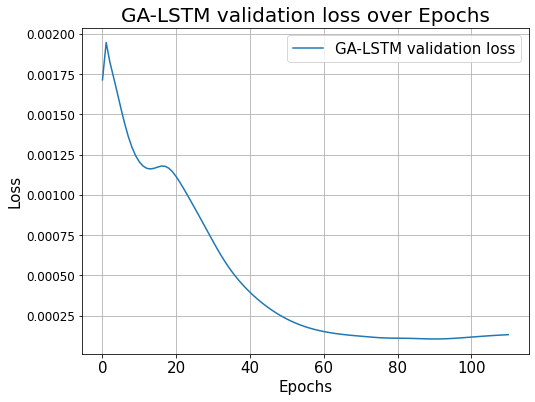

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
plt.plot(history_lstm.history['val_loss'], label='GA-LSTM validation loss')
plt.xlabel('Epochs', fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.yticks(fontsize=12)
plt.title('GA-LSTM validation loss over Epochs', fontsize=20)
plt.grid()
plt.legend(fontsize=15)
plt.savefig("GA-LSTM validation loss.png", format='png', dpi=1600, bbox_inches='tight')
plt.show()

**MinMax Scaler equation**
$$x' = \frac{(x - min)}{(max - min)} \times (new\ max\ value - new\ min\  value) + new\ min\ value$$<br/>


$$x = \frac{(max - min)\times (new\ min\ value + x') + (new\ max\ value - new\ min\ value)\times min}{new\ max\ value - new\ min\ value}$$

Where:

$x$ is the inverse scaled value
$x'$ is the scaled value
$min$ is the minimum value of the original data
$max$ is the maximum value of the original data.<br/>
$new\ max\ value$ and $new\ min\ value$ is the new range that we want to scale the data to. For example: $(1,0)\ or\ (1,-1)$

# LSTM prediction 

In [17]:
# make a prediction 
# select the number of obersvtions for prediction
yhat_lstm_test = model_lstm.predict(test_X, verbose=1)
yhat_lstm_train = model_lstm.predict(train_X, verbose=1)


# invert scaling 
scaled_test_y = pd.DataFrame(test_y)
scaled_train_y = pd.DataFrame(train_y)
scaled_yhat_lstm_test = pd.DataFrame(yhat_lstm_test) ## ravel () converting into 1D array
scaled_yhat_lstm_train = pd.DataFrame(yhat_lstm_train)
#obtain the min and max from the training set
unscaled_train = pd.DataFrame(series_supervised[:len(train)])
#new feature range
new_max_value = 1 
new_min_value= 0
feature_range = new_max_value - new_min_value

def transform_column(column):
    min_value = min(unscaled_train.iloc[:, -steps_ahead + column.name])
    max_value = max(unscaled_train.iloc[:, -steps_ahead + column.name])
    return ((max_value - min_value) * (new_min_value + column) + (feature_range  * min_value)) / feature_range 
    
# invert scaling for actual
y_lstm_test = scaled_test_y.apply(transform_column, axis=0).values
y_lstm_train = scaled_train_y.apply(transform_column, axis=0).values
# invert scaling for forecast
yhat_lstm_test = scaled_yhat_lstm_test.apply(transform_column, axis=0).values
yhat_lstm_train = scaled_yhat_lstm_train.apply(transform_column, axis=0).values

48/48 [==============================] - 0s 6ms/step


In [18]:
# Performance evaluation LSTM
rmse_test = sqrt(mean_squared_error(y_lstm_test, yhat_lstm_test))
print('Test LSTM RMSE: %.5f' % rmse_test)
MAE_test = mean_absolute_error(y_lstm_test, yhat_lstm_test)
print('Test LSTM MAE: %.5f' % MAE_test)
r2 = r2_score(y_lstm_test, yhat_lstm_test)
print('Test LSTM r2: %.5f' % r2)
wMAPE_test = wMAPE(y_lstm_test, yhat_lstm_test)
print('Test LSTM wMAPE: %.5f ' % wMAPE_test)

Test LSTM RMSE: 204.28029
Test LSTM MAE: 113.48826
Test LSTM r2: 0.92351
Test LSTM wMAPE: 4.96879 


In [23]:
# concatenate the actual and LSTM predicetd values for both train adn test sets to be plotted together
entire_actual_lstm = np.concatenate([y_lstm_train,y_lstm_test], axis=0)
entire_forecast_lstm = np.concatenate([yhat_lstm_train,yhat_lstm_test], axis=0)

# Optimizing TCN hyperparameters

In [ ]:
# optimize the TCN model
# define the total number of generations
n_iter = 10
# bits per variable
n_bits = 16
# define the number of combinations (individuals) per generation 
n_pop = 20
# crossover rate
r_cross = 0.9
# mutation rate
r_mut = 0.1

# define the search space for TCN
n_epochs = [500,500]
n_filters_1 = [3, 15]
n_filters_2 = [3, 15]
n_filters_3 = [3, 15]
batch_size = [2, 4]
window_size = [2, 12]
bounds_tcn = [n_epochs, n_filters_1, n_filters_2, n_filters_3, batch_size, window_size]


# run optimization
best_comb_tcn, score_tcn = genetic_algorithm(evaluate_TCN, bounds_tcn, n_bits, n_iter, n_pop, r_cross, r_mut)
print('Done!')
decoded = decode(bounds_tcn, n_bits, best_comb_tcn)
print('TCN Best: %s = %f' % (decoded, score_tcn))

Generation:1
n_epochs 500 n_filters_1 14 n_filters_2 13 n_filters_3 14 batch_size 4 window_size 3
n_epochs 500 n_filters_1 7 n_filters_2 14 n_filters_3 7 batch_size 2 window_size 9
n_epochs 500 n_filters_1 7 n_filters_2 4 n_filters_3 6 batch_size 4 window_size 9
n_epochs 500 n_filters_1 6 n_filters_2 9 n_filters_3 10 batch_size 3 window_size 12
n_epochs 500 n_filters_1 10 n_filters_2 14 n_filters_3 9 batch_size 4 window_size 5
n_epochs 500 n_filters_1 10 n_filters_2 9 n_filters_3 9 batch_size 4 window_size 8
n_epochs 500 n_filters_1 14 n_filters_2 6 n_filters_3 12 batch_size 3 window_size 3
n_epochs 500 n_filters_1 12 n_filters_2 5 n_filters_3 7 batch_size 3 window_size 7
n_epochs 500 n_filters_1 12 n_filters_2 14 n_filters_3 14 batch_size 2 window_size 7
n_epochs 500 n_filters_1 8 n_filters_2 11 n_filters_3 10 batch_size 2 window_size 7
n_epochs 500 n_filters_1 10 n_filters_2 7 n_filters_3 14 batch_size 2 window_size 4
n_epochs 500 n_filters_1 6 n_filters_2 12 n_filters_3 7 batch_size

# Run the TCN model using the optimal hyperparamters obtained by GA

In [24]:
# # # convert series to stationary 
series_diff = series.copy()
# diff_order = 1
# series_diff['BORE_OIL_VOL'] = series_diff['BORE_OIL_VOL'].diff(diff_order)
steps_ahead = 1
# Define hyperparamtes
n_epochs = 500
n_filters_1 = 7
n_filters_2 = 8
n_filters_3 =  6
batch_size = 3
window_size = 9


# # setting the session configurations for reproducibility.
# seed = 2497215193

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ['PYTHONHASHSEED'] = '0'
# seed = int(random.random()*(2**32-1))
np.random.seed(42)
np.random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                    inter_op_parallelism_threads=1)
from keras import backend as K   
tf.random.set_seed(1234)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), 
                        config=session_conf)
K.set_session(sess)

# # convert the series to supervise learning using sliding window approach
series_supervised = series_to_supervised(series_diff, series_diff.columns, n_in= window_size, n_out= steps_ahead, dropnan=True)   

# drop columns we don't want to predict
pattern = re.compile(r"(t-)|^BORE_OIL_VOL.*")

# Extract the column names that match the pattern
matching_columns = [col for col in series_supervised.columns if re.search(pattern, col)]
series_supervised = series_supervised[matching_columns]
# # split into train and test sets
n_features = int((len(series_supervised.columns) -steps_ahead)/window_size)
series_supervised = series_supervised.values
train_size = int(series_supervised.shape[0] * 0.8)
test_size = series_supervised.shape[0] - train_size
train, test = series_supervised[0:train_size], series_supervised[train_size:]
print("train.shape:",train.shape, "test.shape:",test.shape)

# scale  the data to a feature range(0,1)
scaler, train_scaled, test_scaled = scale(train, test)
print('train_scaled.shape:',train_scaled.shape, "test_scaled.shape:",test_scaled.shape)

# # reshape input to be 3D [samples, window_size, features]
train_X, train_y = train_scaled[:, 0:-steps_ahead], train_scaled[:, -steps_ahead:]
train_X = train_X.reshape(train_X.shape[0], window_size, n_features)
test_X, test_y = test_scaled[:, 0:-steps_ahead], test_scaled[:, -steps_ahead:]
test_X = test_X.reshape(test_X.shape[0], window_size, n_features )
print("train_X.shape:",train_X.shape, "train_y.shape:",train_y.shape,
        "test_X.shape:", test_X.shape,"test_y.shape:",test_y.shape)

# build the TCN model
input_tensor=Input(shape=(window_size, n_features))

#Feature extraction module
conv1 = Conv1D(filters = n_filters_1, kernel_size = 1, dilation_rate=1 ,padding='same')(input_tensor)
conv2 = Conv1D(filters = n_filters_2 , kernel_size = 1, dilation_rate=1, padding='same')(conv1)
# Time information extraction module
conv3 = Conv1D(filters = n_filters_3, kernel_size= window_size, dilation_rate=1, padding='causal')(conv2) 

conv3 = Flatten()(conv3)  
outputs = Dense(steps_ahead)(conv3)
model_tcn = Model(input_tensor, outputs)

model_tcn.compile(loss='mean_squared_error',
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

#prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0,
                            restore_best_weights=True, mode='min')
history_tcn = model_tcn.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, callbacks = [early_stopping],
            validation_data=(test_X, test_y), verbose=2, shuffle=False)
model_tcn.evaluate(test_X, test_y)

train.shape: (1518, 28) test.shape: (380, 28)
train_scaled.shape: (1518, 28) test_scaled.shape: (380, 28)
train_X.shape: (1518, 9, 3) train_y.shape: (1518, 1) test_X.shape: (380, 9, 3) test_y.shape: (380, 1)
Epoch 1/500
506/506 - 2s - loss: 0.2437 - val_loss: 0.0147 - 2s/epoch - 4ms/step
Epoch 2/500
506/506 - 1s - loss: 0.0321 - val_loss: 0.0106 - 1s/epoch - 2ms/step
Epoch 3/500
506/506 - 1s - loss: 0.0278 - val_loss: 0.0074 - 973ms/epoch - 2ms/step
Epoch 4/500
506/506 - 1s - loss: 0.0239 - val_loss: 0.0053 - 1s/epoch - 2ms/step
Epoch 5/500
506/506 - 1s - loss: 0.0207 - val_loss: 0.0039 - 1s/epoch - 2ms/step
Epoch 6/500
506/506 - 1s - loss: 0.0179 - val_loss: 0.0030 - 959ms/epoch - 2ms/step
Epoch 7/500
506/506 - 1s - loss: 0.0157 - val_loss: 0.0024 - 924ms/epoch - 2ms/step
Epoch 8/500
506/506 - 1s - loss: 0.0139 - val_loss: 0.0020 - 992ms/epoch - 2ms/step
Epoch 9/500
506/506 - 2s - loss: 0.0125 - val_loss: 0.0017 - 2s/epoch - 4ms/step
Epoch 10/500
506/506 - 3s - loss: 0.0113 - val_loss

0.00010100046347361058

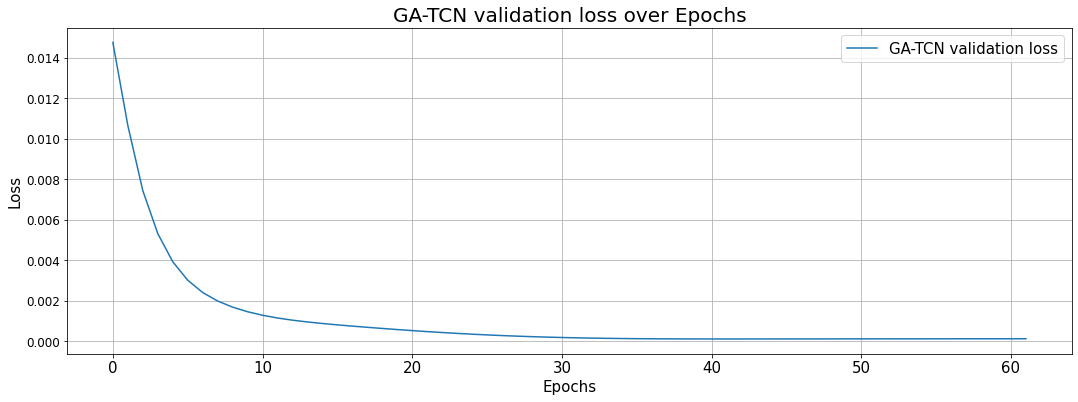

In [95]:
# TCN validation loss over epochs
fig, ax = plt.subplots(1, 1, figsize=(18,6))
plt.plot(history_tcn.history['val_loss'], label='GA-TCN validation loss')
plt.xlabel('Epochs', fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.yticks(fontsize=12)
plt.title('GA-TCN validation loss over Epochs', fontsize=20)
plt.grid()
plt.legend(fontsize=15)
plt.savefig("GA-TCN validation loss.png", format='png', dpi=1600, bbox_inches='tight')
plt.show()

# TCN prediction

In [25]:
# make a prediction 
# select the number of obersvtions for prediction
yhat_tcn_test = model_tcn.predict(test_X, verbose=1)
yhat_tcn_train = model_lstm.predict(train_X, verbose=1)


# invert scaling 
scaled_test_y = pd.DataFrame(test_y)
scaled_train_y = pd.DataFrame(train_y)
scaled_yhat_tcn_test = pd.DataFrame(yhat_tcn_test) ## ravel () converting into 1D array
scaled_yhat_tcn_train = pd.DataFrame(yhat_tcn_train)
#obtain the min and max from the training set
unscaled_train = pd.DataFrame(series_supervised[:len(train)])
#new feature range
new_max_value = 1 
new_min_value= 0
feature_range = new_max_value - new_min_value

def transform_column(column):
    min_value = min(unscaled_train.iloc[:, -steps_ahead + column.name])
    max_value = max(unscaled_train.iloc[:, -steps_ahead + column.name])
    return ((max_value - min_value) * (new_min_value + column) + (feature_range  * min_value)) / feature_range 
    
# invert scaling for actual
y_tcn_test = scaled_test_y.apply(transform_column, axis=0).values
y_tcn_train = scaled_train_y.apply(transform_column, axis=0).values
# invert scaling for forecast
yhat_tcn_test = scaled_yhat_tcn_test.apply(transform_column, axis=0).values
yhat_tcn_train = scaled_yhat_tcn_train.apply(transform_column, axis=0).values

48/48 [==============================] - 1s 4ms/step


In [26]:
# Performance evaluation LSTM
rmse_test = sqrt(mean_squared_error(y_tcn_test, yhat_tcn_test))
print('Test LSTM RMSE: %.5f' % rmse_test)
MAE_test = mean_absolute_error(y_tcn_test, yhat_tcn_test)
print('Test LSTM MAE: %.5f' % MAE_test)
r2 = r2_score(y_tcn_test, yhat_tcn_test)
print('Test LSTM r2: %.5f' % r2)
wMAPE_test = wMAPE(y_tcn_test, yhat_tcn_test)
print('Test LSTM wMAPE: %.5f ' % wMAPE_test)

Test LSTM RMSE: 201.05765
Test LSTM MAE: 122.45935
Test LSTM r2: 0.92590
Test LSTM wMAPE: 5.36157 


In [27]:
# concatenate the actual and LSTM predicetd values for both train adn test sets to be plotted together
entire_actual_tcn = np.concatenate([y_tcn_train,y_tcn_test], axis=0)
entire_forecast_tcn = np.concatenate([yhat_tcn_train,yhat_tcn_test], axis=0)

# Combining the predictions of both modelS GA-LSTM & GA-TCN 

In [47]:
#find the optimal weights for the weighted average metric that will be used for the prediction of TCN-LSTM
# Define a range for the weights to be searched
weights = np.linspace(0.0, 1, 100)
weights = np.round(weights,5)

# Initialize the best weights and best performance
# best_weights = (1,1)
best_performance = float('inf')

# Iterate over all possible weight combinations
for w1 in weights:
    for w2 in weights:        
        # Make predictions using the current weight combination
        predictions = ((w1 * yhat_tcn_test) + (w2 * yhat_lstm_test)) / (w1+w2+1e-10)
        
        # Evaluate the performance using some metric, e.g. accuracy
        performance = sqrt(mean_squared_error(y_tcn_test, predictions))

        # Update the best weights and best performance if the current performance is better
        if performance < best_performance:
            best_weights = (w1, w2)
            best_performance = performance

print("Best weights:", best_weights)
print("Best performance:", best_performance)

Best weights: (0.55556, 0.32323)
Best performance: 199.38657611974884


In [68]:
# Performance evaluation

w1 , w2 = 0.55556,  0.32323
weightedA_test_tcn_lstm = (w1 * yhat_tcn_test + w2 * yhat_lstm_test) / (w1+w2+1e-10)

rmse_test = sqrt(mean_squared_error(y_tcn_test, weightedA_test_tcn_lstm))
print('Test GA-TCN-LSTM RMSE: %.5f' % rmse_test)
MAE_test = mean_absolute_error(y_tcn_test, weightedA_test_tcn_lstm)
print('Test GA-TCN-LSTM MAE: %.5f' % MAE_test)
r2 = r2_score(y_tcn_test, weightedA_test_tcn_lstm)
print('Test GA-TCN-LSTM r2: %.5f' % r2)
wMAPE_test = wMAPE(y_tcn_test, weightedA_test_tcn_lstm)
print('Test GA-TCN-LSTM wMAPE: %.5f ' % wMAPE_test)

Test GA-TCN-LSTM RMSE: 199.38658
Test GA-TCN-LSTM MAE: 117.10746
Test GA-TCN-LSTM r2: 0.92713
Test GA-TCN-LSTM wMAPE: 5.12725 


# Plotting the the forecasted and actual values for the whole dataset

In [78]:
# concatenate the predicted values of train and test sets by LSTM AND TCN
# remove the first one because the tcn window size is 9 steps and target is 10th values while LSTM's window size is 10 and target is 11th value
# when we remove the first actual point for TCN training data, the shape of both training data used for TCN and LSTM will be the same
# the start and end points for test sets used by both models are the same, so all values are retained
actual_entire_lstm_tcn = entire_actual_tcn[1:]
# we will concatenete the predicted values by weighted avaerage for training sets for both LSTM and TCN using the optimal weights that were used 
# to concatenate the test sets for both models 
weightedA_train_tcn_lstm = (w1 * yhat_tcn_train[1:] + w2 * yhat_lstm_train) / (w1+w2+1e-10)
forecast_entire_lstm_tcn = np.concatenate([weightedA_train_tcn_lstm, weightedA_test_tcn_lstm], axis=0)
print("weightedA_train_tcn_lstm.shape:",weightedA_train_tcn_lstm.shape,
      "\nweightedA_test_tcn_lstm.shape",weightedA_test_tcn_lstm.shape,
      "\nforecast_entire_lstm_tcn.shape",forecast_entire_lstm_tcn.shape,
      "\nactual_entire_lstm_tcn.shape",actual_entire_lstm_tcn.shape)


weightedA_train_tcn_lstm.shape: (1517, 1) 
weightedA_test_tcn_lstm.shape (380, 1) 
forecast_entire_lstm_tcn.shape (1897, 1) 
actual_entire_lstm_tcn.shape (1897, 1)


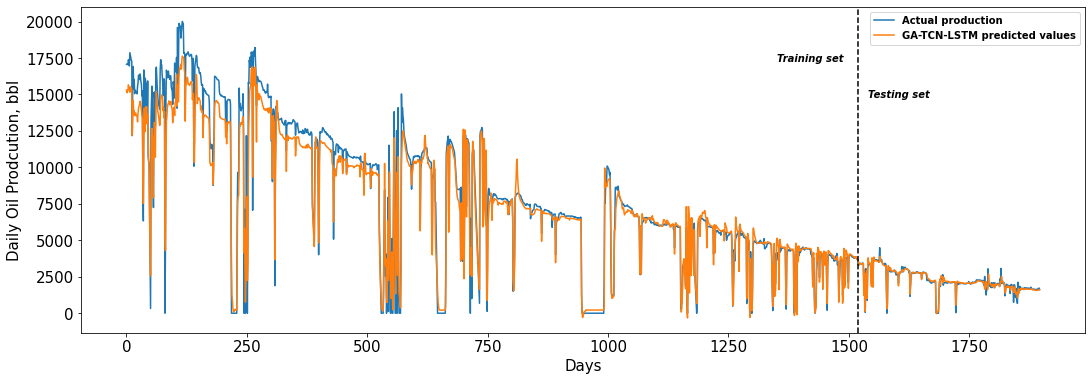

In [104]:
fig, ax = plt.subplots(1, 1, figsize=( 18,6))
plt.plot(actual_entire_lstm_tcn, label = 'Actual production')
plt.plot(forecast_entire_lstm_tcn, label = 'GA-TCN-LSTM predicted values')

# create the horizontal dashed line
plt.axvline(x=train_X.shape[0] + 1, color='black', linestyle='--')
plt.legend()
# add text labels
plt.text(1350, 17500, 'Training set', rotation=0, verticalalignment='center', style='italic', fontweight='bold')
plt.text(1540, 15000, 'Testing set', rotation=0, verticalalignment='center', style='italic', fontweight='bold')

plt.ylabel('Daily Oil Prodcution, bbl', fontsize=15)
plt.xlabel('Days', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Create a font object with bold weight
font = FontProperties()
font.set_weight('bold')
plt.legend(fontsize=10, loc= 'upper right', prop=font)


plt.savefig("GA-TCN-LSTM actual-forecast.png", dpi=1600, bbox_inches='tight')
plt.show()

In [ ]:
# y = inv_scale_y[np.where(inv_scale_y != 0 )]
# yhat = inv_scale_yhat_lstm[np.where(inv_scale_y != 0 )]
plt.plot()

In [ ]:
# # Invert the Differencing for actual 
# df = pd.DataFrame(series.iloc[-len(test)-steps_ahead:,-1])
# n_vars = df.shape[1]
# columns = df.columns
# cols, names = list(), list()
# for i in range(0, steps_ahead):
#     cols.append(df.shift(-i))
#     if i == 0:
#         names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
#     else:
#         names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
# # put it all together
# agg = pd.concat(cols, axis=1)
# agg.columns = names
# agg.dropna(inplace=True)
# agg = agg.iloc[:-1]
# #drop all the variables that we don't want to predict
# #agg.drop(columns=vars_to_drop, inplace=True)
# agg = agg.to_numpy()
# inv_y = np.add(inv_scale_y,agg)

* To invert the differencing of time series for multistep prediction:<br/>
The equation is given by $$
\hat x_{t+h|t}=x_t+(\widehat{\Delta x_{t+1}}+\dots+\widehat{\Delta x_{t+h}}).
$$ <br/>
where: <br/>
$\hat x_{t+h|t}$ is the predicted value of the time series x at time $t$+h, given the value of the time series at time $t$.<br/>
$x_t$ is the value of the time series $x$ at time t.<br/>
${\Delta x_{t+1}}$ is the difference between the value of the time series $x$ at time $t+1$ and the value of the time series at time t.<br/>
${\Delta x_{t+2}}$ is the difference between the value of the time series $x$ at time $t+2$ and the value of the time series at time $t+1$.<br/>
${\Delta x_{t+h}}$ is the difference between the value of the time series $x$ at time $t+h$ and the value of the time series at time $t+h-1$.

In [ ]:
# # Invert the Differencing for forecast
# # to invert the diffrenced predicted values,the the predicted differenced value is added
# # to previous predicted diffenced values and last available observation in test set(Xt) as explained above
# originalSeries_supervised = series_to_supervised(series, series.columns, n_in=window_size, n_out=steps_ahead, dropnan=True)
# current_timestep = 1
# originalSeries_xt = originalSeries_supervised[['BORE_OIL_VOL(t)']]
# # A predicted value at any given step ahead is a result of the previous cumulative differnced predicted values and current time step
# col = []
# inv_yhat_cum = np.cumsum(inv_scale_yhat, axis=1)

# for i in range(n_obs):
#     #.ravel() flattens the series into a one-dimensional array
#     inverted_diff_yhat = originalSeries_xt[-n_obs:].values[i] + inv_yhat_cum[i]
#     col.append(inverted_diff_yhat)
# col = pd.DataFrame(col)
# inv_yhat = col.values # convert df to NumpyArray

In [ ]:
# # Multistep Performance evaluation
# rmse_test, RMSPE_test, MAE_test, MAPE_test, r2_test, wMAPE_test, SMAPE_test  = [], [], [], [], [], [], []
# # calculate the score for each day

# for i in range(test_y.shape[1]):
#     result_rmse = math.sqrt(mean_squared_error(inv_y[:,i], inv_yhat[:,i]))
#     result_RMSPE = RMSPE(inv_y[:,i], inv_yhat[:,i])
#     result_MAE = mean_absolute_error(inv_y[:,i], inv_yhat[:,i])
#     result_MAPE = MAPE(inv_y[:,i], inv_yhat[:,i])
#     result_r2 = r2_score(inv_y[:,i], inv_yhat[:,i])
#     result_wMAPE = wMAPE(inv_y[:,i], inv_yhat[:,i])
#     result_SMAPE = SMAPE(inv_y[:,i], inv_yhat[:,i])

#     rmse_test.append(result_rmse)
#     RMSPE_test.append(result_RMSPE)
#     MAE_test.append(result_MAE)
#     MAPE_test.append(result_MAPE)
#     r2_test.append(result_r2)
#     wMAPE_test.append(result_wMAPE)
#     SMAPE_test.append(result_SMAPE)
    
# ## calculate overall score
# print("The Average scores for the vector output {} steps ahead:\n".format(steps_ahead))
# print('Test RMSE: %.5f' % np.mean(rmse_test))
# #print('Test RMSPE: %.5f' % np.mean(RMSPE_test)) because of that the denominator (actual) has some zero values
# print('Test MAE: %.5f' % np.mean(MAE_test))
# #print('Test MAPE: %.5f' % np.mean(MAPE_test)) #because of that the denominator (actual) has some zero values
# print('Test r2: %.5f' % np.mean(r2_test))
# print('Test wMAPE: %.5f ' % np.mean(wMAPE_test))
# print('Test SMAPE: %.5f ' % np.mean(SMAPE_test))

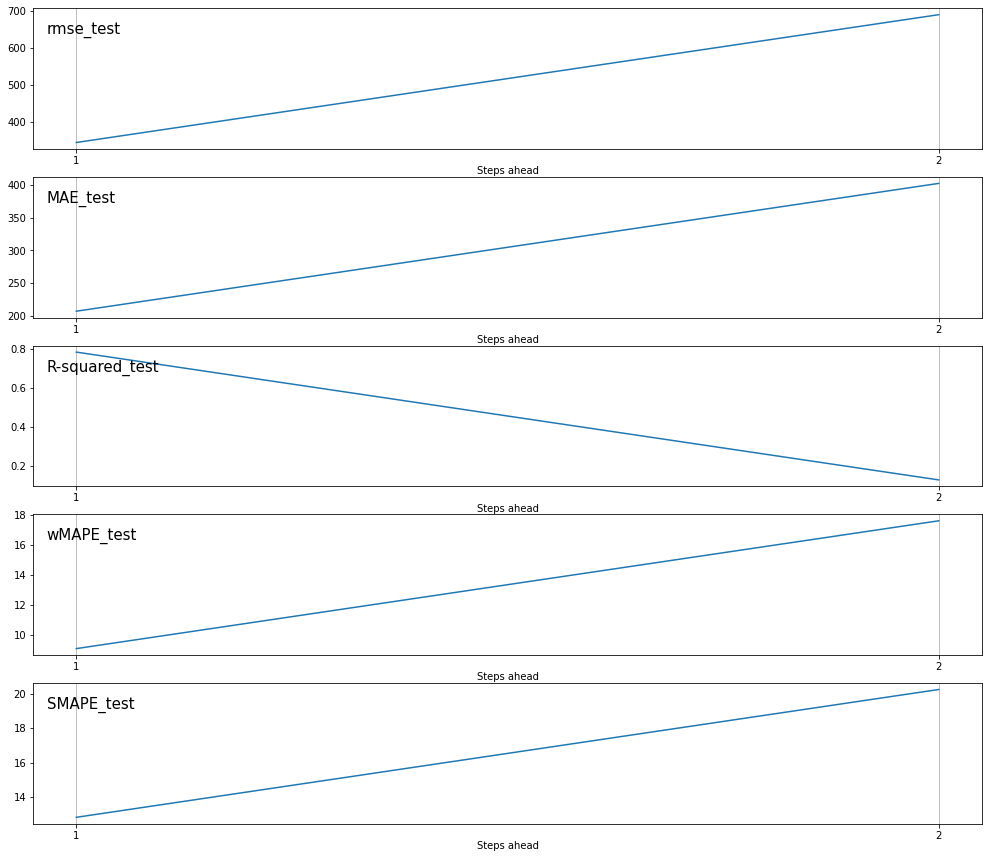

In [ ]:
# # plot the scores for each time step of the multi-step forecast
# scores = pd.DataFrame({"rmse_test":rmse_test, "MAE_test":MAE_test, "R-squared_test":r2_test, "wMAPE_test":wMAPE_test, "SMAPE_test":SMAPE_test})

# # Reset the index, keeping the old index as a column
# scores = scores.reset_index(drop=False)

# # Set the 'index' column as the new index
# scores.index = scores['index'] + 1

# # Drop the old 'index' column
# scores = scores.drop(columns='index')

# data = scores.columns

# # Creating figure with two rows and one column
# fig, axs = plt.subplots(nrows=len(data), figsize=(17, 15))

# axs = axs.ravel()

# for id, column in enumerate(data):
#     # Set the x-axis limits
#     #axs[id].set_xlim(xmin=1, xmax= steps_ahead)
#     #print the name of the test on plot
#     axs[id].plot(scores[column])
#     # Add a title to the x-axis
#     axs[id].set_xlabel('Steps ahead',fontsize=10, labelpad=0.1)
#     axs[id].grid(True)
#     # Remove the horizontal grid lines
#     axs[id].grid(which='both', axis='y')
#     axs[id].xaxis.set_major_locator(plt.MultipleLocator(1))
#     axs[id].legend([column], loc='upper left', fontsize=15, handlelength=0, handletextpad=0, frameon=False)
    
# plt.show()

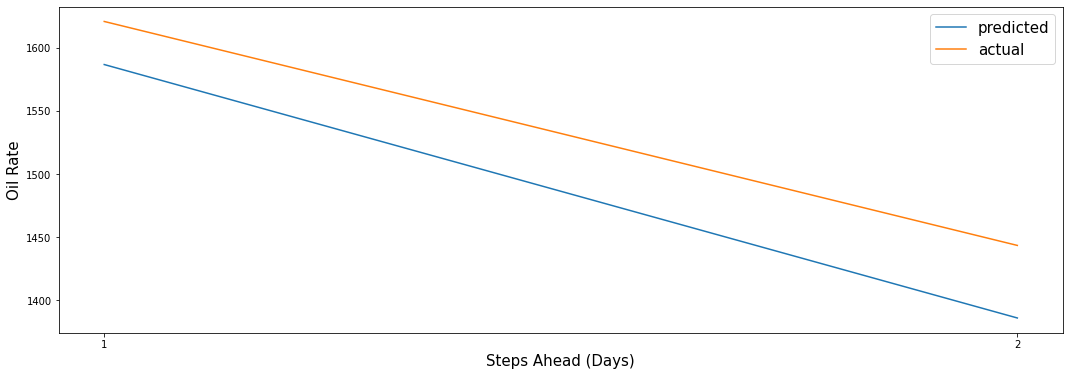

In [ ]:
# plot the last forecasted values on test set
fig, ax = plt.subplots(1, 1, figsize=(18,6)) 
# Set the major locator for the x-axis
x = list(range(1, len(inv_yhat[-1])+1))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.plot(x, inv_yhat[-1], label = "predicted")
ax.plot(x, inv_y[-1], label = "actual")
ax.set_ylabel('Oil Rate', fontsize=15)
ax.set_xlabel('Steps Ahead (Days)',fontsize=15)
plt.legend(fontsize=15)
plt.show()